In [1]:
%matplotlib inline

In [1]:
import fourier_learning

from sklearn.model_selection import train_test_split
import scipy.io
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import Pool
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from scipy.io import savemat
import os

In [2]:
def figsize(scale):
    fig_width_pt = 487.8225     # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27   # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0    # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale # width in inches
    fig_height = fig_width*golden_mean  # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 8,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    }
matplotlib.rcParams.update(pgf_with_latex)

cust_color=["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]
matplotlib.rcParams['savefig.dpi'] = 125
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath,amssymb,amsfonts}"]

<ipython-input-2-db676e3096e5>:28: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath,amssymb,amsfonts}"]


In [3]:
def load_data(data_name):
    try:
        file = "../data/icml_paper/{0}.mat".format(data_name)
        temp_data = scipy.io.loadmat(file)
        X, y = temp_data['X'], temp_data['Y'].squeeze()
        if len(np.unique(y)) > 2:
            type_y = 'categorical'
        else:
            type_y = 'binary'
    except:
        print("No valid data_name entered")
        sys.exit(2)
        
    if type_y == 'binary' or type_y == 'categorical':
        if y.dtype != np.int:
            y = y.astype(np.int, copy=False)

    return X, y, type_y

In [4]:
def load_saved_UFFSfeatures_mohsen(data_name):
    file = "../data/icml_paper/selected_features_UFFS_Mohsen/{0}.mat".format(data_name)
    temp_data = scipy.io.loadmat(file)
    selected_features = np.array(temp_data["SelectedFS"]).squeeze() - 1
    return list(selected_features)

In [5]:
def clf_score_with_feature_selection(X_train, y_train, X_test, y_test, clf, feats_selected):
    X_sel_train = X_train[:, feats_selected]
    X_sel_test = X_test[:, feats_selected]

    clf.fit(X_sel_train, y_train)
    y_sel_pred = clf.predict(X_sel_test)
    return accuracy_score(y_test, y_sel_pred)

In [6]:
# Helper function to call supervised fourier selection
def fourier_feature_selection(X, y, k, approx= "depth_based", depth=2):
    mean_emp = np.mean(X, axis=0)
    std_emp = np.std(X, ddof=1, axis=0)
    fourier_featsel = fourier_learning.SupervisedFourierFS(k, mean_emp, std_emp, approx, depth)
    feats_selected = fourier_featsel.fit(X, y)
    return feats_selected

In [7]:
def remove_zero_variance_fets(X_train, X_test, sel_features_UFFS_X):
    _, d = X_train.shape
    mask = (np.std(X_train, ddof=1, axis=0) > 1e-5)
    valid_features = np.arange(d)
    valid_features = valid_features[mask]
    valid_features = list(set(valid_features).intersection(sel_features_UFFS_X))
    X_train = X_train[:, valid_features]
    X_test = X_test[:, valid_features]
    return X_train, X_test

In [62]:
FIGSIZE_SCALE_REQD = 0.6
def plot_score_vs_t(score_dict, score_original, title):
    fig, ax = plt.subplots(figsize = figsize(FIGSIZE_SCALE_REQD))
    ax = plt.axes(frameon=1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(alpha=1,linestyle='dotted')
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='y', which='minor', left=False)
    for k, scores in score_dict.items():
        t_vec = range(1, len(scores[0])+1)
        p = plt.plot(t_vec, scores[0], label = "$k=${0}".format(k), alpha = 0.7)
        print(scores)
        lower_limit = scores[0] - 1.96*scores[1]/np.sqrt(5)
        upper_limit = scores[0] + 1.96*scores[1]/np.sqrt(5)
        plt.fill_between(t_vec, lower_limit, upper_limit, color = p[0].get_color(), alpha = 0.15)
    plt.axhline(y = score_original[0]*100, color ="black", linestyle ="--", alpha=0.7, 
                label = "no feature selection")
    lower_limit_orig = score_original[0] - 1.96*score_original[1]/np.sqrt(5)
    upper_limit_orig = score_original[0] + 1.96*score_original[1]/np.sqrt(5)
    plt.fill_between(t_vec, lower_limit_orig, upper_limit_orig, color = "black", alpha = 0.2)
    plt.xlabel(r"$t$")
    plt.ylabel("accuracy")
    plt.ylim((50,100))
#     plt.legend(loc='best')
    plt.legend(loc=(0.52,0.02))
    plt.title(title)
    plt.savefig("temp.pdf", bbox_inches='tight', pad_inches = 0.02)
    plt.show()

In [9]:
def original_score_cv(data):
    X, y, type_y = load_data(data)
    skf = model_selection.StratifiedKFold(n_splits=5)
    Accuracies = cross_val_score(clf, X, y, cv=skf)
    scores_mean_orig = np.mean(Accuracies, axis=0)
    scores_std_orig = np.std(Accuracies, axis=0)
    return (scores_mean_orig, scores_std_orig)

In [10]:
def cv_sample_single_run(X, y, k, t, clf, partitions, m, sel_features_UFFS_X = []):
    train_indices, test_indices = partitions[m]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    # Variance threshold --------------------------------------------------
    _, d = X_train.shape
    mask = (np.std(X_train, ddof=1, axis=0) > 1e-5)
    valid_features = np.arange(d)
    valid_features = valid_features[mask]

    valid_features = list(set(valid_features).intersection(sel_features_UFFS_X))
    X_train = X_train[:, valid_features]
    X_test = X_test[:, valid_features]
    # ---------------------------------------------------------------------
#     X_train, X_test = X_train[:,sel_features_UFFS_X], X_test[:,sel_features_UFFS_X]
    # ---------------------------------------------------------------------
    feats_selected = fourier_feature_selection(X_train, y_train, k,
                                                   approx="depth_based", depth=t)
    score_temp = clf_score_with_feature_selection(X_train, y_train, X_test, y_test, clf, feats_selected)
    
    fname = "k-{0}_t-{1}_data_fold_{2}.mat".format(k, t, m)
    fdir = "../results/accuracy_vs_t/{0}_1".format(DATA_NAME)
    if not os.path.exists(fdir):
        os.makedirs(fdir)
    fpath = os.path.join(fdir, fname)
    data_dict = {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}
    savemat(fpath, data_dict)

    fname = "k-{0}_t-{1}_sel-features_fold_{2}.csv".format(k, t, m)
    fpath = os.path.join(fdir, fname)
    np.savetxt(fpath, feats_selected, delimiter=',')

    return score_temp    

In [11]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", C=1, gamma = 'auto'))
])

# Main code

In [18]:
DATA_NAME = "Australian"

In [19]:
X, y, type_y = load_data(DATA_NAME)
print("X.shape: ", X.shape)
sel_features_UFFS_X = load_saved_UFFSfeatures_mohsen(DATA_NAME)
print("len(sel_features_UFFS_X): ",len(sel_features_UFFS_X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y, shuffle=True)
score_original = clf_score_with_feature_selection(X_train, y_train, X_test, y_test, clf, np.arange(X.shape[1]))
print("score_original: ", score_original)

# option 1
X_train, X_test = X_train[:,sel_features_UFFS_X], X_test[:,sel_features_UFFS_X]
#---------
# option 2
# X_train, X_test = remove_zero_variance_fets(X_train, X_test, sel_features_UFFS_X)
# score_original = clf_score_with_feature_selection(X_train, y_train, X_test, y_test, clf, np.arange(X_train.shape[1]))
# print("score_original: ", score_original)
# ---------

X.shape:  (690, 14)
len(sel_features_UFFS_X):  11
score_original:  0.8115942028985508


<ipython-input-3-d8b26a17c42c>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if y.dtype != np.int:
<ipython-input-3-d8b26a17c42c>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [20]:
# out_file = open('./logs.txt', 'a')
# score = []
# max_t = 7
# k = 20
# for t in range(1,max_t):
#     feats_selected = fourier_feature_selection(X_train, y_train, k, approx="depth_based", depth=t)
#     score_temp = clf_score_with_feature_selection \
#             (X_train, y_train, X_test, y_test, clf, feats_selected)
#     score.append(score_temp)
#     print(t,"{0:0.3f}".format(score_temp))

# print("DATA_NAME: ", DATA_NAME, file=out_file)
# print("max_t: {0}, k: {1}".format(max_t, k), file=out_file)
# print("score_original: {0:3f}".format(score_original*100), file=out_file)
# print("score:{0}\n\n".format(np.array(score)*100), sep=", ", file=out_file)
# out_file.close()

Covertype result, k = 10, t = 8
[0.717948717948718,
 0.7521367521367521,
 0.7350427350427351,
 0.7692307692307693,
 0.7350427350427351,
 0.7521367521367521,
 0.7008547008547008,
 0.6324786324786325]

In [21]:
np.random.seed(42)
out_file = open('./logs.txt', 'a')
NO_RUNS = 5
k = 10
max_t = 9
scores_mean = []
scores_std = []
for t in range(1, max_t):
    kf = model_selection.StratifiedKFold(n_splits=NO_RUNS, shuffle=True, random_state=42)
    partitions = list(kf.split(X,y))
#     pool = Pool()
#     args = [(X, y, k, t, clf, partitions, fold_i,
#              sel_features_UFFS_X) for fold_i in range(0, NO_RUNS)]
#     Accuracies = np.array(pool.starmap(cv_sample_single_run, args))
#     pool.close()
    Accuracies = []
    for fold_i in range(NO_RUNS):
        Accuracies.append(cv_sample_single_run(X, y, k, t, clf, partitions, fold_i, sel_features_UFFS_X))
        
    scores_mean_temp = np.mean(Accuracies, axis=0)
    scores_std_temp = np.std(Accuracies, axis=0)
    scores_mean.append(scores_mean_temp)
    scores_std.append(scores_std_temp)
    print(scores_mean)
print("With cross-validation...", file=out_file)
print("DATA_NAME: ", DATA_NAME, file=out_file)
print("max_t: {0}, k: {1}, NO_RUNS: {2}".format(max_t, k, NO_RUNS), file=out_file)
print("score_original: {0:3f}".format(score_original*100), file=out_file)
print("score_mean:{0}".format(np.array(scores_mean)*100), sep=", ", file=out_file)
print("score_std:{0}\n\n".format(np.array(scores_std)*100), sep=", ", file=out_file)
out_file.close()

[0.8492753623188406]
[0.8492753623188406, 0.8507246376811594]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594, 0.8507246376811594]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594, 0.8507246376811594, 0.8536231884057971]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594, 0.8507246376811594, 0.8536231884057971, 0.8536231884057971]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594, 0.8507246376811594, 0.8536231884057971, 0.8536231884057971, 0.8608695652173914]
[0.8492753623188406, 0.8507246376811594, 0.8507246376811594, 0.8507246376811594, 0.8536231884057971, 0.8536231884057971, 0.8608695652173914, 0.855072463768116]


# Plotting

## Coverttype: data1

In [76]:
score_dict = {
    5: [
        np.array([62.64662541, 71.94665488, 72.80872384, 72.80872384, 72.80872384, 72.97671677]), 
        np.array([4.98183816, 2.19629331, 1.32840806, 1.32840806, 1.32840806, 1.18628506])
    ],
    10: [
        np.array([69.18508694, 75.72944297, 72.45652815, 70.39345712, 70.3919835,  69.87474212]),
        np.array([5.38276961, 1.86479883, 1.51960672, 1.22239956, 1.36700677, 2.7720811])
    ],
    20: [
        np.array([74.69643383, 75.21072797, 75.55408193, 75.55408193, 75.7250221,  75.55113469]),
        np.array([1.80483164, 2.18373999, 3.05249155, 3.05249155, 3.70903585, 3.7249758])
    ]
}

In [77]:
# original score
score_original = original_score_cv("Covertype")
score_original = np.array(score_original)

<ipython-input-3-d8b26a17c42c>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if y.dtype != np.int:
<ipython-input-3-d8b26a17c42c>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [78]:
score_original

array([0.69361922, 0.04181356])

[array([62.64662541, 71.94665488, 72.80872384, 72.80872384, 72.80872384,
       72.97671677]), array([4.98183816, 2.19629331, 1.32840806, 1.32840806, 1.32840806,
       1.18628506])]
[array([69.18508694, 75.72944297, 72.45652815, 70.39345712, 70.3919835 ,
       69.87474212]), array([5.38276961, 1.86479883, 1.51960672, 1.22239956, 1.36700677,
       2.7720811 ])]
[array([74.69643383, 75.21072797, 75.55408193, 75.55408193, 75.7250221 ,
       75.55113469]), array([1.80483164, 2.18373999, 3.05249155, 3.05249155, 3.70903585,
       3.7249758 ])]


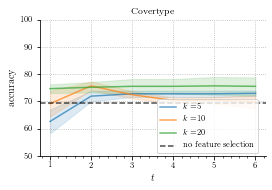

In [80]:
t_vec = range(1,7)
title = "Covertype"
plot_score_vs_t(score_dict, score_original, "Covertype")

## ALL_AML

In [70]:
score_dict = {
    5: [
        np.array([92.95238095, 80.47619048, 87.42857143, 91.52380952, 88.66666667, 91.61904762]), 
        np.array([6.39160447,  8.43274043,  5.4093226,   5.37399466, 11.64244327,  7.0411811 ])
    ],
    10: [
        np.array([97.22222222, 95.83333333, 94.44444444, 94.44444444, 93.05555556, 94.44444444]),
        np.array([4.81125224, 7.73300606, 7.85674201, 7.85674201, 9.5217425,  7.85674201])
    ],
    20: [
        np.array([95.83333333, 97.22222222, 97.22222222, 97.22222222, 97.22222222, 95.83333333]),
        np.array([5.37914354, 4.81125224, 4.81125224, 4.81125224, 4.81125224, 5.37914354])
    ]
}

In [72]:
# original score
score_original = original_score_cv("ALL AML")
score_original = np.array(score_original)

<ipython-input-3-d8b26a17c42c>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if y.dtype != np.int:
<ipython-input-3-d8b26a17c42c>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [73]:
score_original

array([0.86190476, 0.08523677])

[array([92.95238095, 80.47619048, 87.42857143, 91.52380952, 88.66666667,
       91.61904762]), array([ 6.39160447,  8.43274043,  5.4093226 ,  5.37399466, 11.64244327,
        7.0411811 ])]
[array([97.22222222, 95.83333333, 94.44444444, 94.44444444, 93.05555556,
       94.44444444]), array([4.81125224, 7.73300606, 7.85674201, 7.85674201, 9.5217425 ,
       7.85674201])]
[array([95.83333333, 97.22222222, 97.22222222, 97.22222222, 97.22222222,
       95.83333333]), array([5.37914354, 4.81125224, 4.81125224, 4.81125224, 4.81125224,
       5.37914354])]


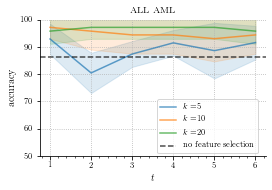

In [75]:
t_vec = range(1,7)
title = "ALL AML"
plot_score_vs_t(score_dict, score_original, title)

## Musk data 13

In [64]:
score_dict = {
    5: [
        np.array([71.21468927, 68.67231638, 68.29096045, 72.70127119, 72.70127119, 68.89830508]), 
        np.array([4.51058388, 5.16638402, 6.40877282 ,3.82199677, 3.82199677, 4.54773747])
    ],
    10: [
        np.array([74.37146893, 72.48587571, 77.95550847, 75.63559322, 74.15960452, 73.95127119]),
        np.array([1.98308052, 3.29071797, 3.60036359, 2.61154334, 2.91425462, 3.02340522])
    ],
    20: [
        np.array([76.26765537, 77.52824859, 83.20268362, 84.45621469, 78.36511299, 76.69491525]),
        np.array([3.77455566, 3.40855235, 1.9842465,  3.60915783, 3.27608838, 4.65281336])
    ]
}

In [66]:
# original score
score_original = original_score_cv("Musk")
score_original = np.array(score_original)

<ipython-input-3-d8b26a17c42c>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if y.dtype != np.int:
<ipython-input-3-d8b26a17c42c>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [67]:
score_original

array([0.80256579, 0.06655359])

[array([71.21468927, 68.67231638, 68.29096045, 72.70127119, 72.70127119,
       68.89830508]), array([4.51058388, 5.16638402, 6.40877282, 3.82199677, 3.82199677,
       4.54773747])]
[array([74.37146893, 72.48587571, 77.95550847, 75.63559322, 74.15960452,
       73.95127119]), array([1.98308052, 3.29071797, 3.60036359, 2.61154334, 2.91425462,
       3.02340522])]
[array([76.26765537, 77.52824859, 83.20268362, 84.45621469, 78.36511299,
       76.69491525]), array([3.77455566, 3.40855235, 1.9842465 , 3.60915783, 3.27608838,
       4.65281336])]


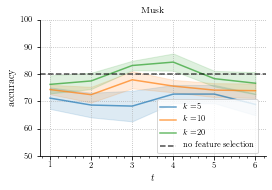

In [69]:
t_vec = range(1,7)
title = "Musk"
plot_score_vs_t(score_dict, score_original, title)

## Australian data 6

In [29]:
# score_dict = {
#     4: [
#         np.array([86.66666667, 86.52173913, 86.37681159, 86.66666667, 85.50724638, 67.82608696,
#  67.82608696, 69.42028986]), 
#         np.array([6.20993776, 6.2520738,  6.67925717, 6.20993776, 5.61301934, 5.17697713,
#  5.17697713, 5.32300512])
#     ],
#     8: [
#         np.array([85.79710145, 86.23188406, 85.94202899, 86.08695652, 86.37681159, 86.23188406,
#  86.08695652, 86.23188406]),
#         np.array([5.53008233, 5.47089452, 5.42462819, 4.54619917, 4.35747721, 5.47089452,
#  5.62049839, 5.31510748])
#     ],
#     10: [
#         np.array([84.92753623, 85.07246377, 85.07246377, 85.07246377, 85.36231884, 85.36231884,
#  86.08695652, 85.50724638]),
#         np.array([2.80276516, 2.92020894, 2.92020894, 2.92020894, 3.22117547, 3.15529581,
#  2.39897759, 3.27292458])
#     ]
# }

In [54]:
score_dict = {
    4: [
        np.array([86.66666667, 86.52173913, 86.37681159, 86.66666667]), 
        np.array([6.20993776, 6.2520738,  6.67925717, 6.20993776])
    ],
    8: [
        np.array([85.79710145, 86.23188406, 85.94202899, 86.08695652, 86.37681159, 86.23188406,
 86.08695652, 86.23188406]),
        np.array([5.53008233, 5.47089452, 5.42462819, 4.54619917, 4.35747721, 5.47089452,
 5.62049839, 5.31510748])
    ],
    10: [
        np.array([84.92753623, 85.07246377, 85.07246377, 85.07246377, 85.36231884, 85.36231884,
 86.08695652, 85.50724638]),
        np.array([2.80276516, 2.92020894, 2.92020894, 2.92020894, 3.22117547, 3.15529581,
 2.39897759, 3.27292458])
    ]
}

In [55]:
# original score
score_original = original_score_cv("Australian")
score_original = np.array(score_original)

<ipython-input-3-d8b26a17c42c>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if y.dtype != np.int:
<ipython-input-3-d8b26a17c42c>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details a

In [56]:
score_original

array([0.85217391, 0.03194987])

[array([86.66666667, 86.52173913, 86.37681159, 86.66666667]), array([6.20993776, 6.2520738 , 6.67925717, 6.20993776])]
[array([85.79710145, 86.23188406, 85.94202899, 86.08695652, 86.37681159,
       86.23188406, 86.08695652, 86.23188406]), array([5.53008233, 5.47089452, 5.42462819, 4.54619917, 4.35747721,
       5.47089452, 5.62049839, 5.31510748])]
[array([84.92753623, 85.07246377, 85.07246377, 85.07246377, 85.36231884,
       85.36231884, 86.08695652, 85.50724638]), array([2.80276516, 2.92020894, 2.92020894, 2.92020894, 3.22117547,
       3.15529581, 2.39897759, 3.27292458])]


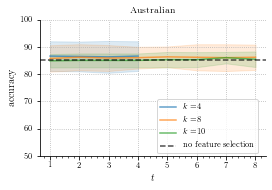

In [63]:
t_vec = range(1,9)
title = "Australian"
plot_score_vs_t(score_dict, score_original, title)

# Temp

In [2]:
import pickle

In [8]:
aa =  pickle.load(open("/home/jithin/fourier_learning/results/E1/sel_features_train.pickle", "rb"))

In [9]:
aa

defaultdict(list,
            {'UFFS + SFFS (t=3)': [array([ 1,  2,  3,  0,  4,  8, 19, 15,  5, 10, 11, 17, 16,  7, 13,  9, 14,
                     12, 18,  6]),
              array([ 0,  3,  4,  1,  2, 15, 19, 14,  5,  9, 10, 18, 17,  8, 12, 13, 11,
                      7,  6, 16]),
              array([ 1,  2,  3,  0,  4, 19, 15, 10, 11,  7,  5,  8, 13,  9, 18,  6, 14,
                     12, 17, 16]),
              array([ 0,  3,  4,  1,  2, 15, 19,  5, 11, 10, 14, 17,  8,  9, 13, 18,  6,
                     12,  7, 16]),
              array([ 1,  2,  3,  0,  4, 15, 10,  8, 19,  5,  7, 17, 13, 11,  9, 18, 16,
                     14, 12,  6])],
             'UFFS + SFFS (t=2)': [array([ 3,  4,  0,  1,  2, 19, 10,  7, 11,  6, 14, 16, 12, 18,  5,  8]),
              array([ 0,  3,  1,  2,  4, 19,  9, 10, 12, 14,  5,  7,  8, 11,  6, 18]),
              array([ 0,  3,  2, 19,  4, 10,  1,  9,  6, 12, 18,  5, 14,  7,  8, 16]),
              array([ 0,  3,  1,  2,  4, 19, 10,  9,  5, 1